In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns
from gerrychain import Graph, GeographicPartition, Partition, Election, accept
from gerrychain.updaters import Tally, cut_edges
import glob
import functools
import operator
import os

In [24]:
def foldl(func, acc, xs):
  return functools.reduce(func, xs, acc)

foldr = lambda func, acc, xs: functools.reduce(lambda x, y: func(y, x), xs[::-1], acc)

In [25]:
def load_npy_files(directory):
    if not os.path.isdir(directory):
        print(f"Error: Directory '{directory}' does not exist.")
        return []

    data = []
    for filename in os.listdir(directory):
        if filename.endswith(".npy"):
            file_path = os.path.join(directory, filename)
            try:
                loaded_array = np.load(file_path)
                data.append(loaded_array)
            except Exception as e:
                print(f"Error loading '{file_path}': {e}")

    return data

In [26]:
dir_path = "./output/short-burst/sb-runs/"
data = load_npy_files(dir_path)
print(data)
print("-"*50)
print("Number of arrays: ", len(data))

[array([[5., 5., 5., ..., 4., 4., 4.],
       [5., 5., 4., ..., 5., 5., 5.],
       [5., 5., 5., ..., 3., 3., 3.],
       ...,
       [5., 4., 4., ..., 3., 3., 3.],
       [5., 5., 5., ..., 4., 3., 3.],
       [5., 4., 4., ..., 3., 3., 3.]]), array([[5., 5., 5., ..., 4., 4., 4.],
       [5., 5., 5., ..., 4., 3., 3.],
       [5., 5., 5., ..., 4., 4., 4.],
       ...,
       [5., 5., 5., ..., 2., 1., 1.],
       [5., 5., 4., ..., 5., 5., 5.],
       [5., 5., 5., ..., 3., 4., 4.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 2., 2., 2.],
       [2., 2., 2., ..., 1., 1., 1.],
       ...,
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 2., 2., 2.],
       [3., 3., 3., ..., 3., 3., 3.]]), array([[5., 5., 5., ..., 3., 3., 3.],
       [5., 5., 5., ..., 5., 5., 4.],
       [5., 5., 5., ..., 5., 5., 5.],
       ...,
       [7., 7., 7., ..., 6., 6., 6.],
       [7., 7., 7., ..., 6., 6., 6.],
       [7., 7., 7., ..., 6., 6., 6.]]), array([[5., 5., 5., ..., 5., 4.

In [27]:
def get_state_runs(state, iters=10000, thresholds=[0.5, 0.45, 0.4], min_col="BVAP", ls=[10]): #TODO: Later run with ls=[10, 25, 50, 100, 200]
    results = {}

    for threshold in thresholds:
        for l in ls:
            file_pattern = "./output/short-burst/sb-runs/{}_dists14_{}_opt_{:.1%}_{}_sbl{}_score_num_opportunity_dists_*.npy".format(state, min_col, threshold, iters, l)
            # print("Searching for files with pattern:", file_pattern)

            sb_runs = glob.glob(file_pattern)

            if not sb_runs:
                print(f"No files found for l = {l} and threshold = {threshold}")
                continue

            try:
                data = [np.load(run) for run in sb_runs]
                results[f"{l}"] = np.array(data)
            except Exception as e:
                print(f"Error loading data for l = {l} and threshold = {threshold}: {e}")

    return results

In [28]:
ga_runs_bvap = get_state_runs("GA", iters=10000, thresholds=[0.5, 0.45, 0.4], min_col="BVAP", ls=[10]) #TODO: Later run with ls=[10, 25, 50, 100, 200]
print(ga_runs_bvap)

{'10': array([[[5., 5., 5., ..., 3., 3., 3.],
        [5., 5., 5., ..., 5., 5., 4.],
        [5., 5., 5., ..., 5., 5., 5.],
        ...,
        [7., 7., 7., ..., 6., 6., 6.],
        [7., 7., 7., ..., 6., 6., 6.],
        [7., 7., 7., ..., 6., 6., 6.]],

       [[5., 5., 5., ..., 5., 4., 4.],
        [5., 4., 4., ..., 4., 4., 4.],
        [5., 5., 5., ..., 5., 5., 5.],
        ...,
        [7., 7., 7., ..., 5., 5., 5.],
        [7., 7., 6., ..., 6., 6., 5.],
        [7., 7., 7., ..., 6., 6., 6.]],

       [[5., 5., 5., ..., 3., 3., 3.],
        [5., 5., 5., ..., 4., 5., 4.],
        [5., 5., 5., ..., 4., 3., 3.],
        ...,
        [7., 7., 6., ..., 6., 6., 6.],
        [7., 7., 7., ..., 6., 6., 6.],
        [7., 7., 7., ..., 6., 6., 5.]],

       ...,

       [[5., 5., 5., ..., 4., 4., 4.],
        [5., 4., 3., ..., 3., 3., 3.],
        [5., 5., 5., ..., 5., 5., 5.],
        ...,
        [7., 7., 7., ..., 7., 7., 6.],
        [7., 7., 7., ..., 5., 5., 5.],
        [7., 6., 6., ...,

In [29]:
def create_state_df(runs, thresholds, iters=10000):
    df_st = []
    for threshold in thresholds:
        for l in runs.keys():
            for i in range(runs[l].shape[0]):
                df = pd.DataFrame()
                df["Step"] = np.arange(iters)

                max_accumulated = np.maximum.accumulate(np.concatenate(runs[l][i]))

                if len(max_accumulated) != iters:
                    print("Error: Length mismatch!")

                df["Maximum"] = max_accumulated
                df["burst_len"] = f"{l}"
                df["threshold"] = threshold
                df_st.append(df)
    return pd.concat(df_st, ignore_index=True)

df_GA_bvap = create_state_df(ga_runs_bvap, thresholds=[0.5, 0.45, 0.4])
df_GA_bvap.head()

,Step,Maximum,burst_len,threshold
0,0,5.0,10,0.5
1,1,5.0,10,0.5
2,2,5.0,10,0.5
3,3,5.0,10,0.5
4,4,5.0,10,0.5


In [30]:
ubs = glob.glob("./output/short-burst/sb-runs/GA_dists14_BVAP_opt_*%_10000_sbl*_score_num_opportunity_dists_*_max_part.p")
ub_runs = {}
for i, run in enumerate(ubs):
     with open(run, "rb") as f:
        ub_runs[i] = pickle.load(f)

In [31]:
runs = list(ub_runs.values())
bvap = foldl(lambda x, y: np.concatenate((x, list(y['BVAP'].values()))), list(runs[0]['BVAP'].values()), runs[1:])

In [32]:
thresholds = [0.5, 0.45, 0.4]
df_GA_bvap = create_state_df(ga_runs_bvap, thresholds)
df_GA_bvap

,Step,Maximum,burst_len,threshold
0,0,5.0,10,0.5
1,1,5.0,10,0.5
2,2,5.0,10,0.5
3,3,5.0,10,0.5
4,4,5.0,10,0.5
...,...,...,...,...
299995,9995,7.0,10,0.4
299996,9996,7.0,10,0.4
299997,9997,7.0,10,0.4
299998,9998,7.0,10,0.4


In [43]:
df_GA_bvap['threshold'].unique()

array([0.5 , 0.45, 0.4 ])

In [44]:
cmap_no_light = ['#e6194b'] 

In [45]:
def separate_df_by_unique_column_values(df, column):
    unique_values = df[column].unique()
    separated_dfs = {}
    for value in unique_values:
        df_name = f"df_{column}_{value}"
        separated_dfs[df_name] = df[df[column] == value]
    return separated_dfs

separated_dfs = separate_df_by_unique_column_values(df_GA_bvap, 'threshold')

In [46]:
df_threshold_50 = separated_dfs['df_threshold_0.5']
df_threshold_45 = separated_dfs['df_threshold_0.45']
df_threshold_40 = separated_dfs['df_threshold_0.4']

In [47]:
df_threshold_50

,Step,Maximum,burst_len,threshold
0,0,5.0,10,0.5
1,1,5.0,10,0.5
2,2,5.0,10,0.5
3,3,5.0,10,0.5
4,4,5.0,10,0.5
...,...,...,...,...
99995,9995,7.0,10,0.5
99996,9996,7.0,10,0.5
99997,9997,7.0,10,0.5
99998,9998,7.0,10,0.5


In [48]:
df_threshold_45

,Step,Maximum,burst_len,threshold
100000,0,5.0,10,0.45
100001,1,5.0,10,0.45
100002,2,5.0,10,0.45
100003,3,5.0,10,0.45
100004,4,5.0,10,0.45
...,...,...,...,...
199995,9995,7.0,10,0.45
199996,9996,7.0,10,0.45
199997,9997,7.0,10,0.45
199998,9998,7.0,10,0.45


In [49]:
df_threshold_40

,Step,Maximum,burst_len,threshold
200000,0,5.0,10,0.4
200001,1,5.0,10,0.4
200002,2,5.0,10,0.4
200003,3,5.0,10,0.4
200004,4,5.0,10,0.4
...,...,...,...,...
299995,9995,7.0,10,0.4
299996,9996,7.0,10,0.4
299997,9997,7.0,10,0.4
299998,9998,7.0,10,0.4


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


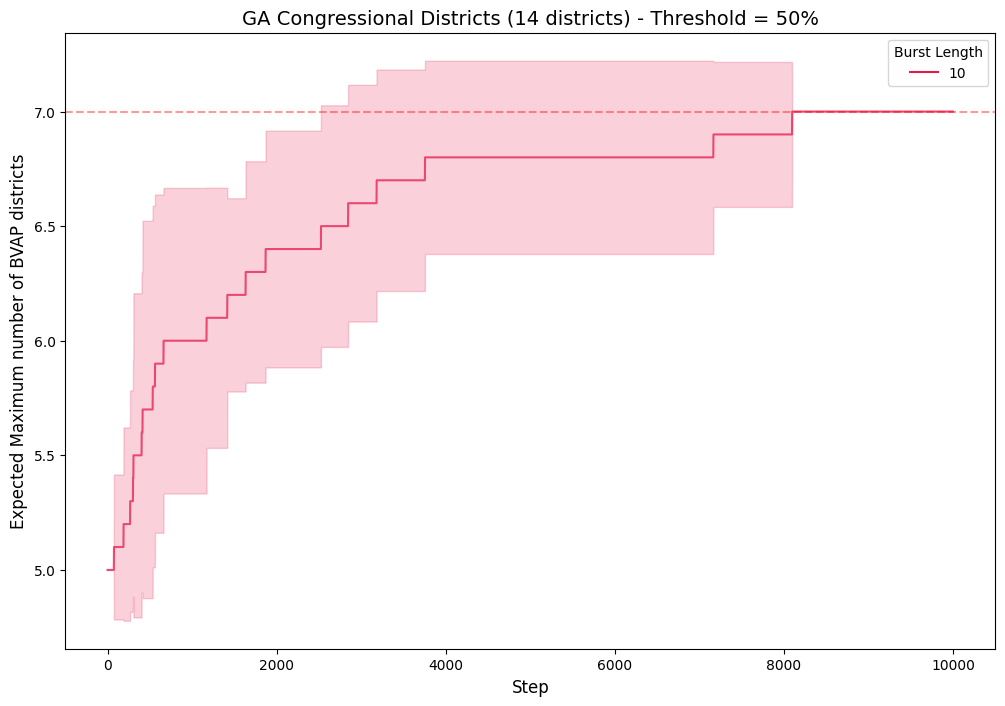

<Figure size 640x480 with 0 Axes>

In [50]:
plt.figure(figsize=(12, 8))
plt.title("GA Congressional Districts (14 districts) - Threshold = 50%", fontsize=14)

sns.lineplot(x="Step", y="Maximum", hue="burst_len", palette=cmap_no_light,
             data=df_threshold_50, errorbar='sd', estimator='mean', alpha=0.75)

plt.ylabel("Expected Maximum number of BVAP districts", fontsize=12)
plt.xlabel("Step", fontsize=12)
plt.legend(title="Burst Length")

peak_value = df_threshold_50["Maximum"].max()
plt.axhline(y=peak_value, color='red', linestyle='--', alpha=0.4)

plt.show()
plt.savefig("./output/short-burst/plots/GA_maxes_all_BVAP_50%.png", dpi=200, bbox_inches='tight')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


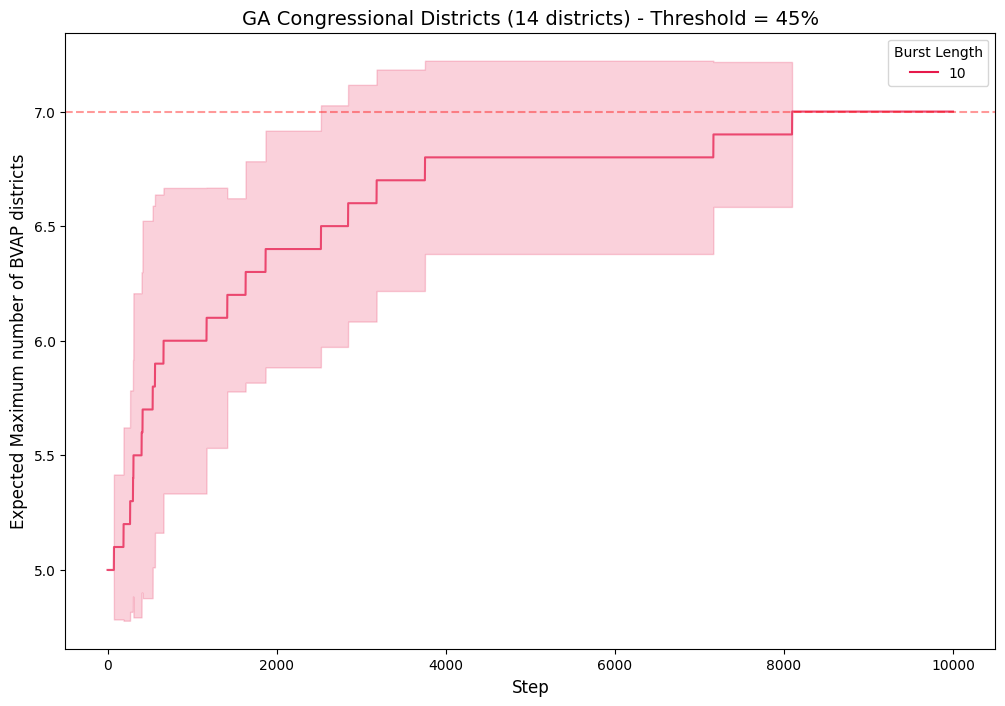

<Figure size 640x480 with 0 Axes>

In [51]:
plt.figure(figsize=(12, 8))
plt.title("GA Congressional Districts (14 districts) - Threshold = 45%", fontsize=14)

sns.lineplot(x="Step", y="Maximum", hue="burst_len", palette=cmap_no_light,
             data=df_threshold_45, errorbar='sd', estimator='mean', alpha=0.75)

plt.ylabel("Expected Maximum number of BVAP districts", fontsize=12)
plt.xlabel("Step", fontsize=12)
plt.legend(title="Burst Length")

peak_value = df_threshold_45["Maximum"].max()
plt.axhline(y=peak_value, color='red', linestyle='--', alpha=0.4)

plt.show()
plt.savefig("./output/short-burst/plots/GA_maxes_all_BVAP_45%.png", dpi=200, bbox_inches='tight')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


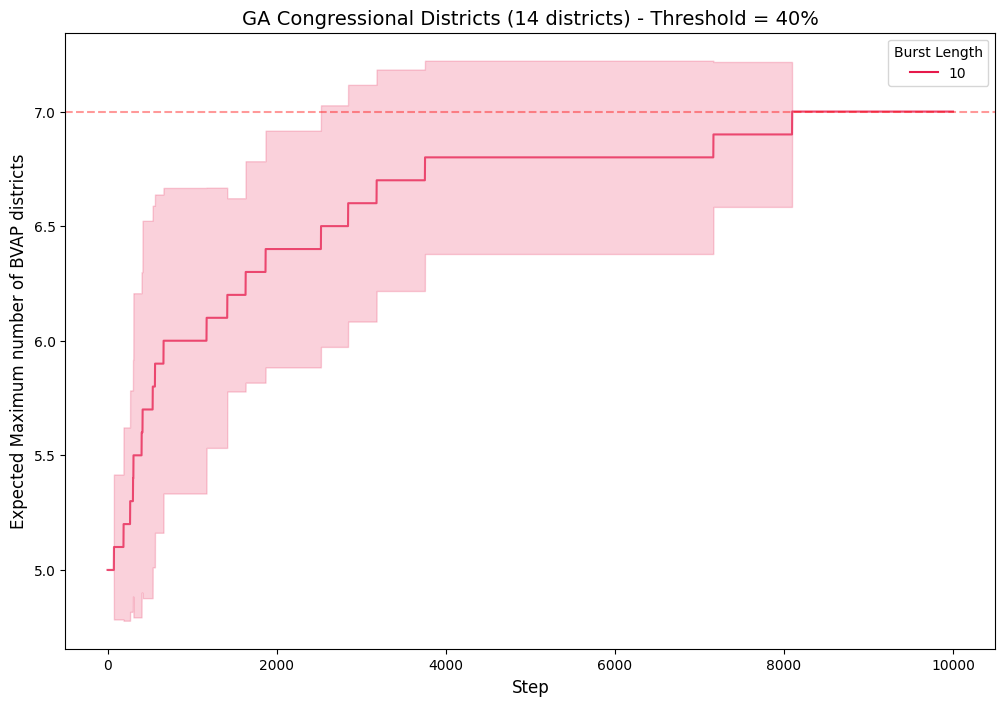

<Figure size 640x480 with 0 Axes>

In [52]:
plt.figure(figsize=(12, 8))
plt.title("GA Congressional Districts (14 districts) - Threshold = 40%", fontsize=14)

sns.lineplot(x="Step", y="Maximum", hue="burst_len", palette=cmap_no_light,
             data=df_threshold_40, errorbar='sd', estimator='mean', alpha=0.75)

plt.ylabel("Expected Maximum number of BVAP districts", fontsize=12)
plt.xlabel("Step", fontsize=12)
plt.legend(title="Burst Length")

peak_value = df_threshold_40["Maximum"].max()
plt.axhline(y=peak_value, color='red', linestyle='--', alpha=0.4)

plt.show()
plt.savefig("./output/short-burst/plots/GA_maxes_all_BVAP_40%.png", dpi=200, bbox_inches='tight')